<a href="https://colab.research.google.com/github/JoYongJIn/YongJin-Repository/blob/main/linear_models_for_regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from google.colab import drive
drive.mount('/content/drive')

import os
os.chdir("/content/drive/MyDrive/Colab Notebooks/")

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/auto-mpg .csv",sep = ",")
df.head()

In [ ]:
df.info()

In [37]:
print(df.dtypes)

mpg             float64
cylinders         int64
displacement    float64
horsepower       object
weight            int64
acceleration    float64
model year        int64
origin            int64
car name         object
dtype: object


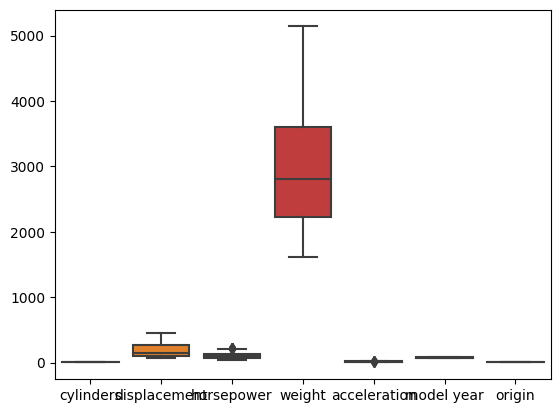

In [38]:
#이상치가 존재하여 standardization으로 스케일링 하는게좋겠다.
df['horsepower'] = pd.to_numeric(df['horsepower'], errors= 'coerce')

sns.boxplot(data=df[['cylinders', 'displacement', 'horsepower', 'weight', 'acceleration', 'model year', 'origin']])
plt.show()

In [ ]:
#타깃값이 연속형인 회귀문제이므로 타깃값도 같이 스케일링해주도록한다.

from sklearn.preprocessing import StandardScaler

# 문자열과 결측치 제외한 데이터프레임 생성
df_numeric = df.select_dtypes(include=[np.number]).dropna()

#표준화 객체 생성
scaler = StandardScaler() #특정 column만 지정하지않고 전부 스케일링하는 코드이다.

# 표준화 수행(마지막 괄호부분에 결측치가 제외된 데이터프레임을 입력해야한다.)
scaled_data = scaler.fit_transform(df_numeric)

# 스케일링된 데이터를 데이터프레임으로 변환(여기도 마지막에 numeric으로 해야함)
scaled_df = pd.DataFrame(scaled_data, columns=df_numeric.columns)

# 결과 출력
print(scaled_df)

In [ ]:
#스케일링한 데이터 결측치 처리
from sklearn.neighbors import NearestNeighbors

# 결측치를 제외한 데이터만 선택
X = scaled_df.dropna()

# NearestNeighbors 객체 생성 (맨하탄 거리 사용)
knn = NearestNeighbors(n_neighbors=5, metric='manhattan')
knn.fit(X)

# 결측치를 보간할 데이터 선택
missing_data = scaled_df[scaled_df.isnull().any(axis=1)]

# 결측치를 보간
for i, row in missing_data.iterrows():
    query = row.dropna().values.reshape(1, -1)
    _, indices = knn.kneighbors(query)
    nearest_values = X.iloc[indices[0]].values
    imputed_values = np.nanmean(nearest_values, axis=0)
    scaled_df.loc[i, scaled_df.columns] = imputed_values

# 결과 출력
print(scaled_df)

In [45]:
# 피처와 타겟 분리: 머신러닝 모델에게 학습을 위한 피처들과 예측하려는 타겟(라벨)을 분리해야 합니다.

X = scaled_df[['cylinders', 'displacement', 'horsepower', 'weight', 'acceleration', 'model year', 'origin']]  # features
y = scaled_df['mpg']  # target variable

In [46]:
#데이터 분할: 데이터를 훈련 세트와 테스트 세트로 분할합니다. 이는 모델의 일반화 성능을 평가하기 위함입니다.

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
#모델 학습
from sklearn.linear_model import LinearRegression

model = LinearRegression()
model.fit(X_train, y_train)

In [47]:
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression

# 모델 정의
model = LinearRegression()

# k-fold 교차 검증 수행
scores = cross_val_score(model, X, y, cv=5, scoring='neg_mean_squared_error')  # scoring 매개변수를 설정합니다.

# 평균 MSE 계산
mean_mse = -scores.mean()  # 음수 값을 다시 양수로 변환합니다.

print("Mean MSE:", mean_mse)

Mean MSE: 0.24786327396876126


In [48]:
#1차부터 5차까지 linear regression 해보며 성능확인하기
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

degrees = [1, 2, 3, 4, 5]  # 다항식의 차수 리스트

for degree in degrees:
    # 다항식 변환
    poly_features = PolynomialFeatures(degree=degree)
    X_poly = poly_features.fit_transform(X_train)  # X_train은 입력 변수 데이터

    # 다항 회귀 모델 훈련
    model = LinearRegression()
    model.fit(X_poly, y_train)  # y_train은 타겟 변수 데이터

    # 테스트 데이터에 대한 예측
    X_poly_test = poly_features.transform(X_test)  # X_test는 테스트 데이터
    y_pred = model.predict(X_poly_test)

    # 모델 평가
    mse = mean_squared_error(y_test, y_pred)
    print(f"Degree {degree}: MSE = {mse}")

#성능은 2차일때가 가장좋다.

Degree 1: MSE = 0.1762735632628969
Degree 2: MSE = 0.11778202802496222
Degree 3: MSE = 0.28745820466948485
Degree 4: MSE = 328.5861023641374
Degree 5: MSE = 18.525535436443526


In [50]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_squared_error

# 다항식 변환
poly_features = PolynomialFeatures(degree=3)
X_poly = poly_features.fit_transform(X_train)  # X_train은 입력 변수 데이터

# Ridge 회귀 모델 정의
ridge = Ridge()

# Grid Search에 사용할 매개변수 그리드
param_grid = {'alpha': [0.1, 0.5, 1.0, 2.0, 5.0]}

# Grid Search 수행
grid_search = GridSearchCV(ridge, param_grid, cv=5, scoring='neg_mean_squared_error')
grid_search.fit(X_poly, y_train)

# 최적의 alpha 값 및 모델 출력
best_alpha = grid_search.best_params_['alpha']
print("Best Alpha:", best_alpha)

# 최적의 alpha 값으로 Ridge 회귀 모델 재훈련
model = make_pipeline(poly_features, Ridge(alpha=best_alpha))
model.fit(X_train, y_train)

# 테스트 데이터에 대한 예측
y_pred = model.predict(X_test)

# 모델 평가
mse = mean_squared_error(y_test, y_pred)
print("MSE:", mse)

#파라미터가 최적화되어 MSE가 아주작아진것을 보면 성능이 향상되었음을 알수있다.

Best Alpha: 5.0
MSE: 0.11338239348417391
